In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive/resnet_miniproject/

Mounted at /content/drive/
/content/drive/MyDrive/resnet_miniproject


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data

from model_dropout import ResidualBlock, ResNet
from train_eval_util import train, evaluate, calculate_accuracy, epoch_time, total_params, total_layers, get_predictions, plot_confusion_matrix
from dataset import train_data, valid_data, test_data

import time
import numpy as np 
import matplotlib.pyplot as plt

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')  
else:
    device = torch.device('cpu')

print(f"Selected device: {device}")

Selected device: cuda


In [4]:
BATCH_SIZE = 32

train_iterator = DataLoader(train_data, batch_size= BATCH_SIZE, shuffle=True)
valid_iterator =  DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_iterator =  DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
model = ResNet(ResidualBlock, [5, 5, 5], dropout_rate = 0.2).to(device)

print(f"Total number of layers: {total_layers(model)}")
print(f"Total number of parameters: {total_params(model)}")

from torchsummary import summary
summary(model, (3, 32, 32))

Total number of layers: 32
Total number of parameters: 466906
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
           Dropout-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 16, 32, 32]           2,304
       BatchNorm2d-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
     ResidualBlock-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
          Dropout-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 3

In [6]:
num_epochs = 200
train_acc_history = []
train_loss_history = []
valid_acc_history = []
valid_loss_history = []
lr_epoch = []

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    
    scheduler.step()
    lr_now = lr_now = optimizer.param_groups[0]['lr']
    lr_epoch.append(lr_now)

    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    end_time = time.time()

        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | LR: {lr_now:.6f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    

    train_acc_history.append(train_acc)
    train_loss_history.append( train_loss)
    valid_acc_history.append(valid_acc)
    valid_loss_history.append(valid_loss)

Epoch: 01 | Epoch Time: 0m 47s
	Train Loss: 1.574 | Train Acc: 41.75% | LR: 0.001000
	 Val. Loss: 1.278 |  Val. Acc: 52.73%
Epoch: 02 | Epoch Time: 0m 45s
	Train Loss: 1.203 | Train Acc: 56.63% | LR: 0.001000
	 Val. Loss: 1.122 |  Val. Acc: 60.05%
Epoch: 03 | Epoch Time: 0m 44s
	Train Loss: 1.018 | Train Acc: 63.97% | LR: 0.000999
	 Val. Loss: 0.857 |  Val. Acc: 69.31%
Epoch: 04 | Epoch Time: 0m 45s
	Train Loss: 0.900 | Train Acc: 68.48% | LR: 0.000999
	 Val. Loss: 0.830 |  Val. Acc: 71.06%
Epoch: 05 | Epoch Time: 0m 44s
	Train Loss: 0.813 | Train Acc: 71.54% | LR: 0.000998
	 Val. Loss: 0.799 |  Val. Acc: 72.61%
Epoch: 06 | Epoch Time: 0m 45s
	Train Loss: 0.762 | Train Acc: 73.34% | LR: 0.000998
	 Val. Loss: 0.695 |  Val. Acc: 76.41%
Epoch: 07 | Epoch Time: 0m 44s
	Train Loss: 0.714 | Train Acc: 75.28% | LR: 0.000997
	 Val. Loss: 0.623 |  Val. Acc: 78.62%
Epoch: 08 | Epoch Time: 0m 44s
	Train Loss: 0.678 | Train Acc: 76.56% | LR: 0.000996
	 Val. Loss: 0.617 |  Val. Acc: 79.78%
Epoch: 0

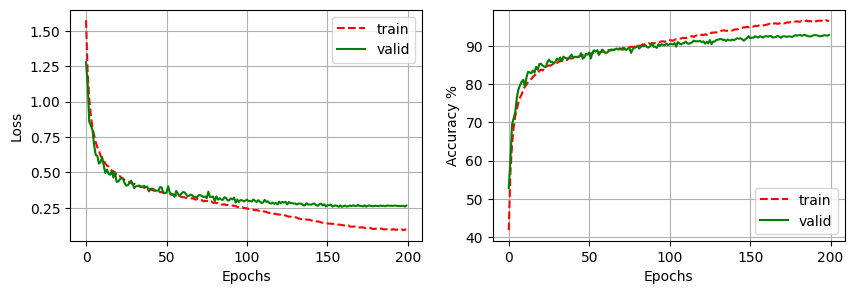

In [36]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(range(num_epochs), train_loss_history, '--r')
ax1.plot(range(num_epochs), valid_loss_history, '-g')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend(['train', 'valid'])

ax2.plot(range(num_epochs), np.array(train_acc_history) * 100, '--r')
ax2.plot(range(num_epochs), np.array(valid_acc_history) * 100, '-g')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy %')
ax2.grid()
ax2.legend(['train', 'valid'])


In [40]:
torch.save(model, 'model_dropout.pt')

In [37]:
import numpy as np 

np.save('history_dropout/train_acc_history.npy', train_acc_history)
np.save('history_dropout/train_loss_history.npy', train_loss_history )
np.save('history_dropout/valid_acc_history.npy', valid_acc_history )
np.save('history_dropout/valid_loss_history.npy', valid_loss_history)
np.save('history_dropout/lr_per_epoch.npy', lr_epoch, )

In [38]:
# final_model = torch.load('model.pt')
test_loss, test_accurcy = evaluate(model, test_iterator, criterion, device)
print(f'test loss: {test_loss:.3f}, validation: {test_accurcy*100:.3f}')

test loss: 0.256, validation: 92.742
